In [1]:
import KID_model_functions as kids
import fitting_KID_model_functions as fitkids
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy import units as u

In [2]:
alpha = 0.73*u.dimensionless_unscaled
f = 331.6*u.MHz
Tstage = 0.215*u.K
Tc = 1.39*u.K
TBB_0 = 6.0*u.K
V = 38*1.5*0.8*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film, minus 20% for overetching trace width
eta_pb = 0.57
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

In [3]:
trans=0.03

eta_opt = 0.8*u.dimensionless_unscaled
n_star = 1318*(np.power(u.micron,-3))
tau_max = 35*u.microsecond

In [4]:
TBBoptdata,f0optdata,xoptdata,sxxoptdata = np.loadtxt('optical_response_evap_devices/CD012_reduced_Res0.csv',delimiter=',',unpack=True)

In [5]:
Pincoptdata = kids.TBB_to_Pinc(TBBoptdata,trans=trans)

In [6]:
TBBoptpts = np.sort(list(set(TBBoptdata)))
Pincoptpts = kids.TBB_to_Pinc(TBBoptpts,trans=trans)

In [7]:
f0optpts = []
f0opterr = []
xoptpts = []
xopterr = []
sxxoptpts = []
sxxopterr = []


In [8]:
for temp in TBBoptpts:
    inds = np.where(TBBoptdata == temp)
    
    f0optpts.append(np.average(f0optdata[inds]))
    f0opterr.append(np.std(f0optdata[inds])/np.sqrt(len(inds)))
    
    xoptpts.append(np.average(xoptdata[inds]))
    xopterr.append(np.std(xoptdata[inds])/np.sqrt(len(inds)))
    
    sxxoptpts.append(np.average(sxxoptdata[inds]))
    sxxopterr.append(np.std(sxxoptdata[inds])/np.sqrt(len(inds)))
    

In [9]:
Tstagedarkdata,f0darkdata,xdarkdata,sxxdarkdata = np.loadtxt('optical_response_evap_devices/CD011_reduced_Res0.csv',delimiter=',',unpack=True)

In [10]:
Tstagedarkpts = np.sort(list(set(Tstagedarkdata)))
f0darkpts = []
f0darkerr = []
xdarkpts = []
xdarkerr = []
sxxdarkpts = []
sxxdarkerr = []

In [11]:
for temp in Tstagedarkpts:
    inds = np.where(Tstagedarkdata == temp)
    
    f0darkpts.append(np.average(f0darkdata[inds]))
    f0darkerr.append(np.std(f0darkdata[inds])/np.sqrt(len(inds)))
    
    xdarkpts.append(np.average(xdarkdata[inds]))
    xdarkerr.append(np.std(xdarkdata[inds])/np.sqrt(len(inds)))
    
    sxxdarkpts.append(np.average(sxxdarkdata[inds]))
    sxxdarkerr.append(np.std(sxxdarkdata[inds])/np.sqrt(len(inds)))
    

In [12]:
# triple simultaneous fit of x_opt,sxx_opt,sxx_dark for n_star,tau_max,eta_Opt, df,Sxx_0_Opt,S_xx_0_dark
# Independent variable
xdata = np.concatenate((TBBoptpts,TBBoptpts,Tstagedarkpts))
print(xdata)
len(xdata)
print(xdata[0:len(TBBoptpts)])
print(xdata[len(TBBoptpts):2*len(TBBoptpts)])
print(xdata[-len(Tstagedarkpts)::])

[5.61  5.75  5.95  6.65  7.1   7.45  7.8   5.61  5.75  5.95  6.65  7.1
 7.45  7.8   0.215 0.225 0.25  0.275 0.3   0.325]
[5.61 5.75 5.95 6.65 7.1  7.45 7.8 ]
[5.61 5.75 5.95 6.65 7.1  7.45 7.8 ]
[0.215 0.225 0.25  0.275 0.3   0.325]


In [ ]:
# Parameters to hold constant in the fit
alpha = 0.73*u.dimensionless_unscaled
f = 331.6*u.MHz
Tstage = 0.215*u.K
Tc = 1.39*u.K
TBB_0 = 6.0*u.K
V = 38*1.5*0.8*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film, minus 20% for overetching trace width
eta_pb = 0.57
trans = 0.03
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

# function to fit x vs TBB
xoptfunc = lambda T_BBi,n_starp,tau_maxp,eta_optp,dfp: kids.xMB(alpha,f,Tstage,Tc,T_BBi,V,n_starp,tau_maxp,eta_pb,eta_optp,trans,N0)+(dfp*np.power(f.unit,-1)*f)
# function to fit Sxx vs TBB
sxxoptfunc = lambda T_BBi,n_starp,tau_maxp,eta_optp,Sxx0optp: kids.Sxx(alpha,f,Tstage,Tc,T_BBi,V,n_starp,tau_maxp,eta_pb,nu_opt,eta_optp,trans,N0).value+Sxx0optp
# function to fit Sxx vs Tstage
sxxdarkfunc = lambda T_stagei,n_starp,tau_maxp,Sxx0darkp: kids.Sxx(alpha,f,T_stagei,Tc,TBB_0,V,n_starp,tau_maxp,eta_pb,nu_opt,eta_opt=0,trans=0,N0=N0).value+Sxx0darkp

combfunc = lambda datai,n_starp,tau_maxp,eta_optp,dfp,Sxx0optp,Sxx0darkp: np.concatenate((xoptfunc(datai[0:len(TBBoptpts)],n_starp,tau_maxp,eta_optp,dfp),sxxoptfunc(datai[len(TBBoptpts):2*len(TBBoptpts)],n_starp,tau_maxp,eta_optp,Sxx0optp),sxxdarkfunc(datai[-len(Tstagedarkpts)::],n_starp,tau_maxp,Sxx0darkp)))
#def combfunc(datai,nstarp,taumaxp,eta_optp,dfp,Sxx0optp,Sxx0darkp): 
#    xopt = xoptfunc(datai[0:len(TBBoptpts)],n_starp,tau_maxp,eta_optp,dfp)
#    sxxopt = sxxoptfunc(datai[len(TBBoptpts):2*len(TBBoptpts)],n_starp,tau_maxp,eta_optp,Sxx0optp)
#    sxxdark = sxxdarkfunc(datai[-len(Tstagedarkpts)::],n_starp,tau_maxp,Sxx0darkp)
#    np.concatenate((xopt,sxxopt,sxxdark))

ydata = np.concatenate((xoptpts,sxxoptpts,sxxdarkpts))
yerr = np.concatenate((xopterr,sxxopterr,sxxdarkerr))
p0 = [1000,50,.8,1e-8,1e-17,1e-17]
bounds = ([10,10,0,0,1e-19,1e-19],[1e5,1e4,1,1e-17,1e-17])
                       
comb_popt,comb_pcov = curve_fit(combfunc,xdata,ydata,p0=p0,sigma=yerr)
print(comb_popt)

In [ ]:
n_star_fit,tau_max_fit,eta_opt_fit,df_fit,Sxx0opt_fit,Sxx0dark_fit = comb_popt

Tstagefit = np.linspace(Tstagedarkpts.min(),Tstagedarkpts.max(),num=50)
sxxdarkfit = sxxdarkfunc(Tstagefit,n_star_fit,tau_max_fit,Sxx0dark_fit)

TBBfit = np.linspace(TBBoptpts.min(),TBBoptpts.max(),num=50)
xoptfit = xoptfunc(TBBfit,n_star_fit,tau_max_fit,eta_opt_fit,df_fit)
sxxoptfit = sxxoptfunc(TBBfit,n_star_fit,tau_max_fit,eta_opt_fit,Sxx0opt_fit)

In [78]:
cell_text = [[r'$n^*$','{:.0f}'.format(n_star_fit),r'$\mu m^{-3}$'], 
             [r'$\tau_{max}$','{:.0f}'.format(tau_max_fit),'microseconds'], 
             [r'$\eta_{opt}$','{:.0f}'.format(100*eta_opt_fit),'%'], 
             ['df','{:.1e}'.format(df_fit),r'MHz$^{-1}$'], 
             [r'$Sxx_{0,opt}$','{:.1e}'.format(Sxx0opt_fit),r'Hz$^{-1}$'], 
             [r'$Sxx_{0,dark}$','{:.1e}'.format(Sxx0dark_fit),r'Hz$^{-1}$']]

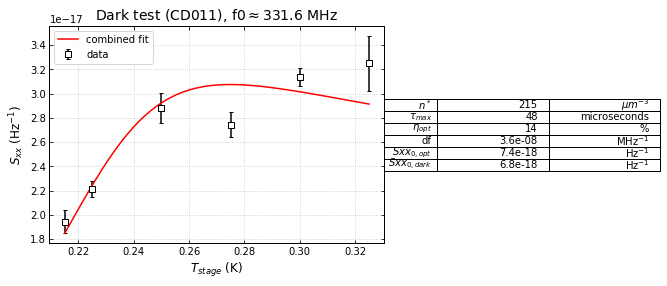

In [87]:
plt.errorbar(x=Tstagedarkpts,y=sxxdarkpts,yerr=sxxdarkerr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
plt.plot(Tstagefit,sxxdarkfit,'r-',label='combined fit')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.xlabel(r'$T_{stage}$ (K)')
plt.ylabel(r'$S_{xx}$ (Hz$^{-1}$)')
plt.title(r'Dark test (CD011), f0$\approx$331.6 MHz')
plt.legend(loc='upper left')
#plt.savefig('CD011_res0_sxx_vs_Tstage.png')

the_table = plt.table(cellText=cell_text, loc='right')
                      #rowLabels=rows)
                      #loc='right')
        
the_table.auto_set_column_width(0)
#plt.tight_layout(h_pad=5.0)
plt.subplots_adjust(hspace=5.0)

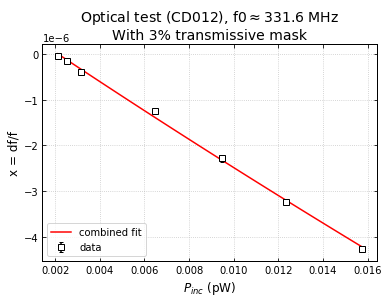

In [29]:
plt.errorbar(x=Pincoptpts.value,y=xoptpts,yerr=xopterr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
plt.plot(kids.TBB_to_Pinc(TBBfit,trans),xoptfit,'r-',label='combined fit')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.xlabel(r'$P_{inc}$ (pW)')
plt.ylabel('x = df/f')
plt.title(r'Optical test (CD012), f0$\approx$331.6 MHz' + '\n' + 'With 3% transmissive mask')
plt.legend(loc='lower left')
#plt.savefig('CD012_res0_x_vs_Pinc.png')


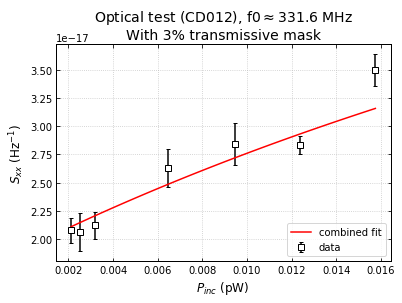

In [31]:
plt.errorbar(x=Pincoptpts.value,y=sxxoptpts,yerr=sxxopterr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
plt.plot(kids.TBB_to_Pinc(TBBfit,trans),sxxoptfit,'r-',label='combined fit')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.xlabel(r'$P_{inc}$ (pW)')
plt.ylabel(r'$S_{xx}$ (Hz$^{-1}$)')
plt.title(r'Optical test (CD012), f0$\approx$331.6 MHz' + '\n' + 'With 3% transmissive mask')
plt.legend(loc='lower right')
#plt.savefig('CD012_res0_sxx_vs_Pinc.png')

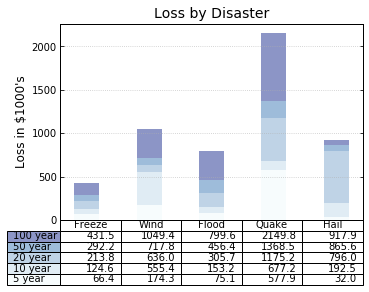

In [66]:
import numpy as np
import matplotlib.pyplot as plt


data = [[ 66386, 174296,  75131, 577908,  32015],
        [ 58230, 381139,  78045,  99308, 160454],
        [ 89135,  80552, 152558, 497981, 603535],
        [ 78415,  81858, 150656, 193263,  69638],
        [139361, 331509, 343164, 781380,  52269]]

columns = ('Freeze', 'Wind', 'Flood', 'Quake', 'Hail')
rows = ['%d year' % x for x in (100, 50, 20, 10, 5)]

values = np.arange(0, 2500, 500)
value_increment = 1000

# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
n_rows = len(data)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append(['%1.1f' % (x / 1000.0) for x in y_offset])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel("Loss in ${0}'s".format(value_increment))
plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.xticks([])
plt.title('Loss by Disaster')

plt.show()

In [33]:
cell_text

[['431.5', '1049.4', '799.6', '2149.8', '917.9'],
 ['292.2', '717.8', '456.4', '1368.5', '865.6'],
 ['213.8', '636.0', '305.7', '1175.2', '796.0'],
 ['124.6', '555.4', '153.2', '677.2', '192.5'],
 ['66.4', '174.3', '75.1', '577.9', '32.0']]

In [34]:
rows

['100 year', '50 year', '20 year', '10 year', '5 year']

In [ ]:
columns